# Fitting interaction parameters of binary systems

Sometimes Equations of State needs an extra help to better predict behaviours.

Let's see how we can optimize binary interaction parameters of a Cubic Equation,
using equilibria data.

## Data structure
For all the default approachs of parameter optimization the datapoints must
be in the format of a `pandas` DataFrame, with the following columns:

- `kind`: Which kind of point is defined `["bubble", "dew", "liquid-liquid", "PT"]`.
- `T`: Temperature (in Kelvin).
- `P`: Pressure (in bar).
- `x1`: Mole fraction of component 1 (lightest component) in heavy phase. 
- `y1`: Mole fraction of component 1 (lightest component) in light phase.

In the following cell we import the datapoints from a `.csv` file

In [1]:
import pandas as pd
df = pd.read_csv('./data/CO2_C6.csv')
df

,kind,T,P,x1,y1
0,bubble,303.15,20.24,0.2385,0.9721
1,bubble,303.15,30.36,0.3698,0.9768
2,bubble,303.15,39.55,0.5063,0.9815
3,bubble,303.15,50.95,0.7078,0.9842
4,bubble,303.15,57.83,0.8430,0.9855
5,bubble,303.15,64.68,0.9410,0.9884
6,bubble,303.15,67.46,0.9656,0.9909
7,bubble,315.15,20.84,0.2168,0.9560
8,bubble,315.15,30.40,0.3322,0.9660
9,bubble,315.15,40.52,0.4446,0.9748


## Default model prediction

Before starting to fit BIPs, let's see how the model predicts without BIPs.

First, let's define the model

In [2]:
import yaeos

Tc = [304.1, 504.0]
Pc = [73.75, 30.12]
w = [0.4, 0.299]

model = yaeos.PengRobinson76(Tc, Pc, w)

### Claculation of Pxy diagrams
Now that the model is defined, lets calculate Pxy diagrams for each temperature.

First, we find the unique values of temperature to iterate over them later.

In [3]:
Ts = df["T"].unique()
Ts

array([303.15, 315.15])

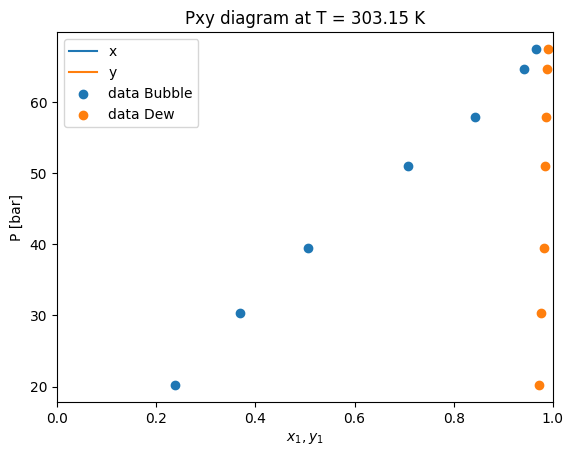

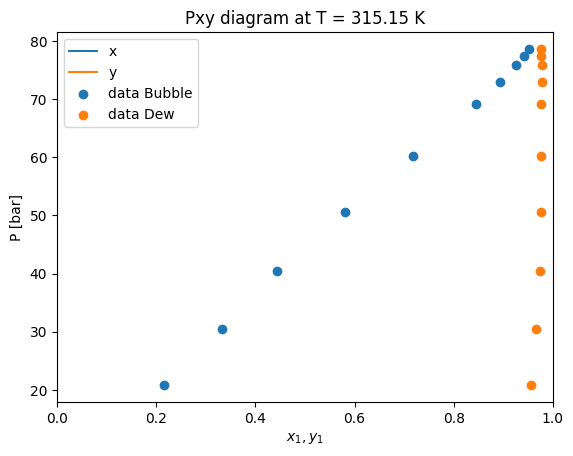

In [4]:
import matplotlib.pyplot as plt

z0 = [0, 1]
zi = [1, 0]

for T in Ts:

    # Let's use a mask to only get the data for a specific temperature
    mask = df["T"] == T
    px = model.phase_envelope_px(z0=z0, zi=zi, temperature=T, a0=0.001, ns0=len(z0)+3)

    plt.plot(px.main_phases_compositions[:, 0, 0], px["P"], label="x")
    plt.plot(px.reference_phase_compositions[:, 0], px["P"], label="y")

    plt.scatter(df[mask]["x1"], df[mask]["P"], label="data Bubble")
    plt.scatter(df[mask]["y1"], df[mask]["P"], label="data Dew")

    plt.title(f"Pxy diagram at T = {T} K")
    plt.ylabel("P [bar]")
    plt.xlabel(r"$x_1, y_1$")
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

Here we can see that the PengRobinson EoS present a negative deviation with
respect to the experimental points. Let's se how we can improve these
predictions.

## Definition of the optimization problem

Now that we already have our data points defined. We need to define the
optimization problem.

The `yaeos.fitting` package includes the `BinaryFitter` object, this object
encapsulates all the logic that is needed to fit binary systems.

In [5]:
import yaeos
from yaeos.fitting import BinaryFitter

BinaryFitter?

### Model setter function

Looking at the object's documentation we can see that we need to define a
function `model_setter` that takes the vector of fitting parameters and extra
required arguments.

In [6]:
def fit_kij(x, model):
    """Fit kij function.

    Args:
        x (list): kij value.
        model (yaeos.CubicEoS): CEOS model that will be fitted
    """
    kij = x[0]

    kij_matrix = [
        [0, kij], 
        [kij, 0]
    ]

    lij = [
        [0, 0],
        [0, 0]
    ]

    mixrule = yaeos.QMR(kij=kij_matrix, lij=lij)

    model.set_mixrule(mixrule)
    
    return model

In [7]:
problem = BinaryFitter(
    model_setter=fit_kij,
    model_setter_args=(model,),
    data=df,
    verbose=True
)

x0 = [0.0]

problem.fit(x0, bounds=None)

1.7427277515958346 [0.]
1.7367297572626244 [0.00025]
1.7307370080649485 [0.0005]
1.72474952538773 [0.00075]
1.712790445469462 [0.00125]
1.700852689778661 [0.00175]


1.6770418462495278 [0.00275]
1.6533183947480148 [0.00375]
1.6061393533646415 [0.00575]
1.559327111499111 [0.00775]
1.4668506368944916 [0.01175]
1.3759871697248645 [0.01575]
1.199517124958797 [0.02375]


1.030807090584202 [0.03175]
0.7207125515768745 [0.04775]
0.45494890252076453 [0.06375]
0.1633296153190301 [0.09575]
0.22052696455206036 [0.12775]
0.22052696455206036 [0.12775]


0.09792206009347366 [0.11175]
0.22052696455206036 [0.12775]
0.11825669217983152 [0.10375]
0.10598288555962829 [0.11975]
0.09823429765712599 [0.11575]


0.10459879763851507 [0.10775]
0.09712360613884066 [0.11375]
0.09823429765712599 [0.11575]
0.09730049165208345 [0.11275]
0.05599850855641941 [0.11475]
0.09823429765712599 [0.11575]
0.09823429765712599 [0.11575]


0.05537507866049399 [0.11425]
0.09712360613884066 [0.11375]
0.05567258588798029 [0.1145]
0.05510588012730981 [0.114]
0.09712360613884066 [0.11375]
0.09712360613884066 [0.11375]


0.05523694758807889 [0.114125]
0.054981862883314914 [0.113875]
0.09712360613884066 [0.11375]
0.09712360613884066 [0.11375]
0.05504299106424188 [0.1139375]


## Optimization result
Now that we have fitted the parameter, let's see the solution. For this, we
can see the `solution` property of the problem.
Where we can see that the optimization terminated succesfully with a `kij` value
of around `0.113`

In [8]:
problem.solution

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.054981862883314914
             x: [ 1.139e-01]
           nit: 21
          nfev: 42
 final_simplex: (array([[ 1.139e-01],
                       [ 1.139e-01]]), array([ 5.498e-02,  5.504e-02]))

### Obtain the fitted model
Now that the problem has been optimized, let's redefine our model with the
solution. For this, we use the `_get_model` method inside of the `BinaryFitter`
object. This just uses the function that we have provided originally (`fit_kij`)

In [9]:
model = problem._get_model(problem.solution.x, model)

### Make predictions
Let's repeat the calculation of Pxy diagrams that we have done earlier

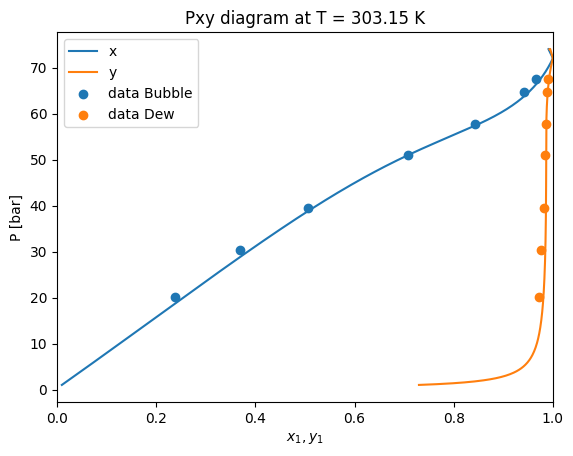

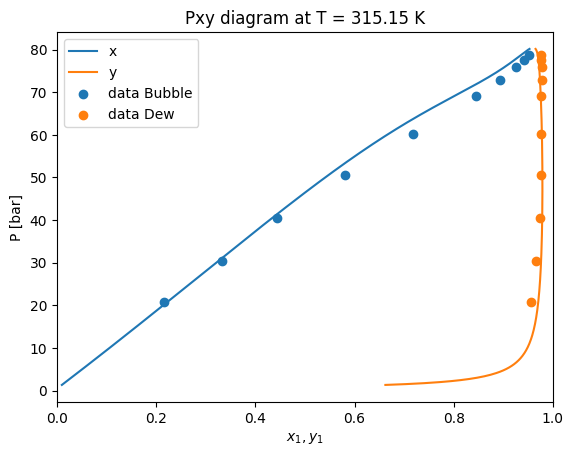

In [10]:
for T in Ts:

    # Let's use a mask to only get the data for a specific temperature
    mask = df["T"] == T
    px = model.phase_envelope_px(z0=z0, zi=zi, temperature=T, ds0=1e-5, max_points=500, a0=0.01)

    plt.plot(px.main_phases_compositions[:, 0, 0], px["P"], label="x")
    plt.plot(px.reference_phase_compositions[:, 0], px["P"], label="y")

    plt.scatter(df[mask]["x1"], df[mask]["P"], label="data Bubble")
    plt.scatter(df[mask]["y1"], df[mask]["P"], label="data Dew")

    plt.title(f"Pxy diagram at T = {T} K")
    plt.ylabel("P [bar]")
    plt.xlabel(r"$x_1, y_1$")
    plt.xlim(0, 1)
    plt.legend()
    plt.show()